#Object Localization

In [58]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-7oquwsnj
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-7oquwsnj
  Resolved https://github.com/albumentations-team/albumentations to commit c79683632e31a78c5c1c12881d323cd3e46a432a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [59]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [60]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [61]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [62]:
csv = "/content/object-localization-dataset/train.csv"
dataDir = "/content/object-localization-dataset/"

device = 'cuda'
batchSize  =16
imgSize = 140

LR = 0.001
epochs = 80
modelName = 'efficientnet_b0'

numCor = 4

In [63]:
df = pd.read_csv(csv)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


Training Data example

/content/object-localization-dataset/train_images/mushroom_20.jpg


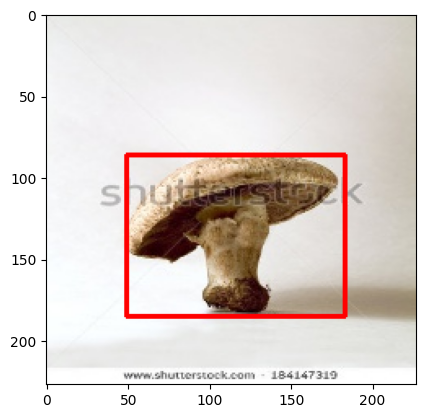

In [64]:
row = df.iloc[2]
# Print the image path to check for errors
print(dataDir + row.img_path)
img = cv2.imread(dataDir + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Showing bounding box
pt1 = (row.xmin, row.ymin)
p2 = (row.xmax, row.ymax)
bndBox = cv2.rectangle(img, pt1, p2, (255, 0, 0), 2)
plt.imshow(img)

In [65]:
trainDF,validDF = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [66]:
import albumentations as A

In [67]:
trainAugs = A.Compose([
    A.Resize(imgSize, imgSize),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

validAugs = A.Compose([
    A.Resize(imgSize, imgSize),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


#Custom Dataset

In [68]:
class ObjLocDatset(torch.utils.data.Dataset):
    def __init__(self, df, augs = None):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax
        bbox = [[xmin, ymin, xmax, ymax]]

        img = cv2.imread(dataDir + row.img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augs:
            data = self.augs(image=img, bboxes=bbox, class_labels=[None])
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
        bbox = torch.tensor(bbox)
        return img, bbox

In [69]:
trainSet = ObjLocDatset(trainDF, trainAugs)
validSet = ObjLocDatset(validDF, validAugs)

In [70]:
print(f"Total examples in the trainset: {len(trainSet)}")
print(f"Total examples in the validset: {len(validSet)}")

Total examples in the trainset: 148
Total examples in the validset: 38


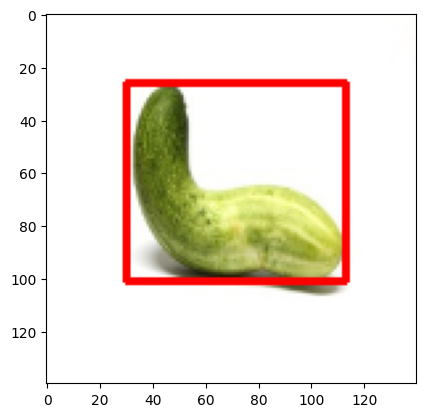

In [71]:
img, bbox = trainSet[34]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

#Loading dataset into batches

In [72]:
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True)
validLoader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=False)

In [73]:
print("Total no. batches in trainloader : {}".format(len(trainLoader)))
print("Total no. batches in validloader : {}".format(len(validLoader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [74]:
for images,bboxes in trainLoader:
    break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Creating the model

In [75]:
from torch import nn
import timm

In [76]:
class ObjLocModel(nn.Module):
    def __init__(self):
        super(ObjLocModel, self).__init__()
        self.backbone = timm.create_model(modelName, pretrained=True, num_classes=numCor)

    def forward(self, images,gt_bboxes=None):
        bboxes = self.backbone(images)
        if gt_bboxes != None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
        return bboxes

In [77]:
model = ObjLocModel()
model.to(device)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): C

In [78]:
randomImg = torch.rand(1,3,140,140).to(device)
model(randomImg).shape

torch.Size([1, 4])

#Creating Train and Eval Function

In [79]:
def trainFunc(model, dataLoader, optimizer):
    model.train()
    totalLoss = 0.0

    for data in tqdm(dataLoader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(device), gt_bboxes.to(device)

        bboxes, loss = model(images, gt_bboxes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        totalLoss += loss.item()

    return totalLoss / len(dataLoader)

In [80]:
def evalFunc(model, dataLoader, ):
    model.eval()
    totalLoss = 0.0

    with torch.no_grad():
      for data in tqdm(dataLoader):
          images, gt_bboxes = data
          images, gt_bboxes = images.to(device), gt_bboxes.to(device)

          bboxes, loss = model(images, gt_bboxes)
          totalLoss += loss.item()

      return totalLoss / len(dataLoader)

#Training Loop

In [81]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [82]:
bestValidLoss = np.inf

for i in range(epochs):
    trainLoss = trainFunc(model, trainLoader, optimizer)
    validLoss = evalFunc(model, validLoader)

    if validLoss < bestValidLoss:
      print("Valid Loss Improved from {} to {}".format(bestValidLoss, validLoss))
      bestValidLoss = validLoss
      torch.save(model.state_dict(), 'bestModel.pt')

    print(f"Epoch : {i+1} Train Loss : {trainLoss} Valid Loss : {validLoss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from inf to 3942.631103515625
Epoch : 1 Train Loss : 5337.481518554688 Valid Loss : 3942.631103515625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 3942.631103515625 to 932.0713094075521
Epoch : 2 Train Loss : 1828.2261352539062 Valid Loss : 932.0713094075521


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 932.0713094075521 to 249.6375935872396
Epoch : 3 Train Loss : 1039.2778686523438 Valid Loss : 249.6375935872396


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 249.6375935872396 to 164.75048319498697
Epoch : 4 Train Loss : 757.5403991699219 Valid Loss : 164.75048319498697


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 164.75048319498697 to 146.90165201822916
Epoch : 5 Train Loss : 532.1772644042969 Valid Loss : 146.90165201822916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 369.6389892578125 Valid Loss : 155.65729268391928


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 305.32641448974607 Valid Loss : 196.38101704915366


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 228.0752151489258 Valid Loss : 187.20665486653647


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 148.9921615600586 Valid Loss : 161.3829803466797


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 146.90165201822916 to 127.3871358235677
Epoch : 10 Train Loss : 141.22161102294922 Valid Loss : 127.3871358235677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 127.3871358235677 to 116.08800506591797
Epoch : 11 Train Loss : 107.03766555786133 Valid Loss : 116.08800506591797


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 116.08800506591797 to 92.77729161580403
Epoch : 12 Train Loss : 106.3881061553955 Valid Loss : 92.77729161580403


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 92.77729161580403 to 86.89296849568684
Epoch : 13 Train Loss : 97.07795104980468 Valid Loss : 86.89296849568684


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 86.89296849568684 to 84.72336069742839
Epoch : 14 Train Loss : 95.25190162658691 Valid Loss : 84.72336069742839


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 73.10753898620605 Valid Loss : 92.34293111165364


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 73.701318359375 Valid Loss : 85.9316037495931


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 84.72336069742839 to 81.41111755371094
Epoch : 17 Train Loss : 99.0800567626953 Valid Loss : 81.41111755371094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 75.12484283447266 Valid Loss : 86.26957194010417


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 80.29954795837402 Valid Loss : 86.50304667154948


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 81.41111755371094 to 63.87405014038086
Epoch : 20 Train Loss : 69.23670768737793 Valid Loss : 63.87405014038086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 63.5889368057251 Valid Loss : 88.93737538655598


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 57.919146347045896 Valid Loss : 68.7787259419759


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 63.87405014038086 to 58.11120351155599
Epoch : 23 Train Loss : 58.80395927429199 Valid Loss : 58.11120351155599


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 77.50534439086914 Valid Loss : 100.1911112467448


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 55.016898727416994 Valid Loss : 61.304971059163414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 58.11120351155599 to 53.84105618794759
Epoch : 26 Train Loss : 49.940761184692384 Valid Loss : 53.84105618794759


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27 Train Loss : 49.11265182495117 Valid Loss : 71.02107747395833


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 Train Loss : 46.57425308227539 Valid Loss : 57.116564432779946


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 Train Loss : 36.44314727783203 Valid Loss : 57.252235412597656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 Train Loss : 38.90023918151856 Valid Loss : 55.40576171875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 53.84105618794759 to 46.64373906453451
Epoch : 31 Train Loss : 36.812029647827146 Valid Loss : 46.64373906453451


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 Train Loss : 36.475030708312985 Valid Loss : 62.15814336140951


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 Train Loss : 30.619816017150878 Valid Loss : 54.223456700642906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 46.64373906453451 to 46.3209425608317
Epoch : 34 Train Loss : 52.28099536895752 Valid Loss : 46.3209425608317


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 Train Loss : 42.82216567993164 Valid Loss : 59.35975329081217


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 Train Loss : 32.50879459381103 Valid Loss : 69.85938517252605


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 Train Loss : 29.833319664001465 Valid Loss : 62.0697275797526


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 46.3209425608317 to 43.75250244140625
Epoch : 38 Train Loss : 25.75750665664673 Valid Loss : 43.75250244140625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 Train Loss : 30.883993530273436 Valid Loss : 45.22069231669108


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 Train Loss : 32.53443908691406 Valid Loss : 46.275054931640625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 41 Train Loss : 35.080591678619385 Valid Loss : 56.71863810221354


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 42 Train Loss : 29.603987312316896 Valid Loss : 47.469245274861656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 43 Train Loss : 47.46178970336914 Valid Loss : 46.154290517171226


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 44 Train Loss : 26.99896183013916 Valid Loss : 79.6443862915039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 45 Train Loss : 23.00556182861328 Valid Loss : 57.45040067036947


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 43.75250244140625 to 36.2292849222819
Epoch : 46 Train Loss : 31.03551197052002 Valid Loss : 36.2292849222819


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 36.2292849222819 to 35.48623593648275
Epoch : 47 Train Loss : 37.07075357437134 Valid Loss : 35.48623593648275


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 48 Train Loss : 38.01307020187378 Valid Loss : 48.853118896484375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 49 Train Loss : 36.21073665618896 Valid Loss : 42.068528493245445


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 50 Train Loss : 28.805045795440673 Valid Loss : 49.11346944173177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 51 Train Loss : 28.407926845550538 Valid Loss : 44.55322519938151


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 52 Train Loss : 24.42470226287842 Valid Loss : 45.24835713704427


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 53 Train Loss : 29.57869634628296 Valid Loss : 38.43995602925619


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 54 Train Loss : 32.52987260818482 Valid Loss : 45.61334482828776


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 55 Train Loss : 29.330811023712158 Valid Loss : 39.98747634887695


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 56 Train Loss : 40.22497816085816 Valid Loss : 35.70758056640625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 57 Train Loss : 26.924353694915773 Valid Loss : 39.92765808105469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 58 Train Loss : 23.425983810424803 Valid Loss : 44.16852315266927


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 59 Train Loss : 31.814125347137452 Valid Loss : 45.82743008931478


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 60 Train Loss : 37.4136568069458 Valid Loss : 43.4427433013916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 61 Train Loss : 29.523286437988283 Valid Loss : 46.26591873168945


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 62 Train Loss : 28.13332805633545 Valid Loss : 47.87303924560547


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 35.48623593648275 to 34.66096051534017
Epoch : 63 Train Loss : 29.84910430908203 Valid Loss : 34.66096051534017


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 64 Train Loss : 35.797426795959474 Valid Loss : 38.372763315836586


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 65 Train Loss : 38.87030954360962 Valid Loss : 45.3772939046224


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 66 Train Loss : 34.75281963348389 Valid Loss : 38.479536056518555


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 34.66096051534017 to 32.03547318776449
Epoch : 67 Train Loss : 24.335922241210938 Valid Loss : 32.03547318776449


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 68 Train Loss : 26.086341762542723 Valid Loss : 39.337917963663735


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 69 Train Loss : 43.92485795021057 Valid Loss : 38.20854695638021


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 70 Train Loss : 27.844654178619386 Valid Loss : 35.85963567097982


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 71 Train Loss : 21.762521696090698 Valid Loss : 39.6186408996582


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 72 Train Loss : 28.832193470001222 Valid Loss : 35.758731842041016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 73 Train Loss : 30.01159429550171 Valid Loss : 36.609902699788414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 74 Train Loss : 23.232968854904176 Valid Loss : 35.226575215657554


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 75 Train Loss : 21.602702713012697 Valid Loss : 33.293432553609215


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 76 Train Loss : 24.020243167877197 Valid Loss : 33.93389765421549


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 77 Train Loss : 22.692888259887695 Valid Loss : 39.66685549418131


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 78 Train Loss : 24.986179161071778 Valid Loss : 32.04958248138428


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 79 Train Loss : 25.701815128326416 Valid Loss : 37.84683163960775


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 80 Train Loss : 21.20879430770874 Valid Loss : 32.32264105478922


#Inference

In [83]:
import utils

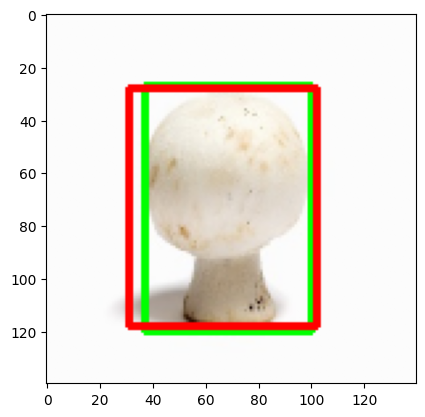

In [85]:
model.load_state_dict(torch.load('bestModel.pt'))
model.eval()

#Example
with torch.no_grad():
    image, gt_bbox = validSet[34]
    image = image.unsqueeze(0).to(device)
    outBbox = model(image)

    utils.compare_plots(image, gt_bbox, outBbox)